<a href="https://colab.research.google.com/github/ArifAygun/Iron-Ore-Froth-Flotation-Quality-Prediction/blob/main/AA_Iron_Ore_Froth_Flotation_Quality_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Quality Prediction of Iron Ore Mining Flotation Process**

##**1. Problem Definition**

**Gangue concentrate predict in the reverse cationic flotation:**


Mined ores are mostly mixtures of extractable minerals and nonvaluable material (gangue). Mineral processing (e.g. ore dressing, ore beneficiation) follows mining and prepares the ore for extraction of the valuable metal. A principal step in mineral processing is physical separation of the particles of valuable minerals from the gangue, to produce an enriched portion (concentrate) containing most of the valuable minerals, and a discard (tailing) containing predominantly the gangue.

A separation of minerals by exploiting difference of surface properties (hydrophobicity) is called flotation. **The reverse cationic flotation** is commonly used to separate iron from silica. By adjusting the 'chemistry' of the pulp by adding various chemical reagents, iron minerals remain in the water and create sediment with a high concentration of iron (valuable minerals). At the same time, silica particles (gangue) attach to air bubbles and float to the surface.

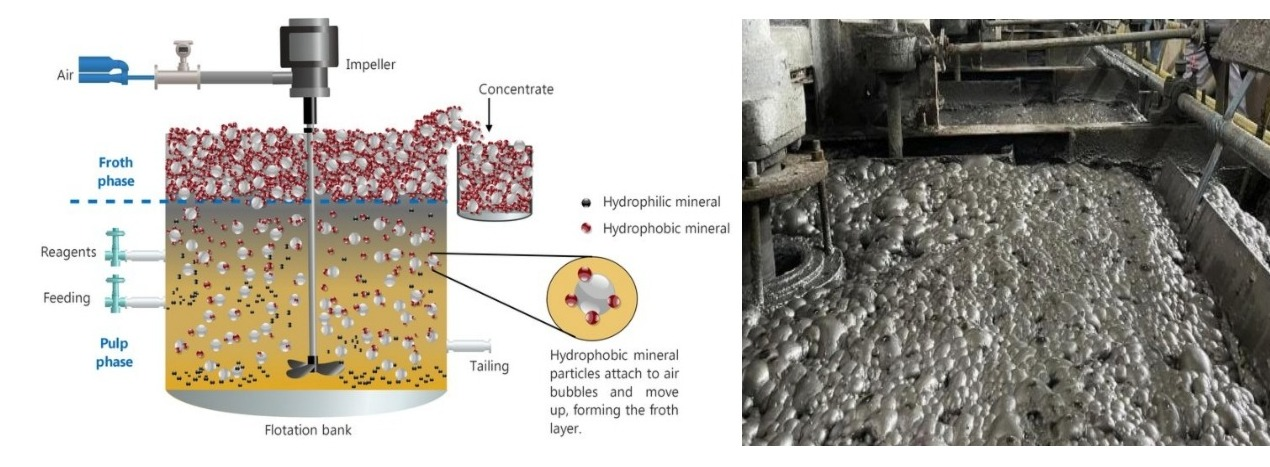

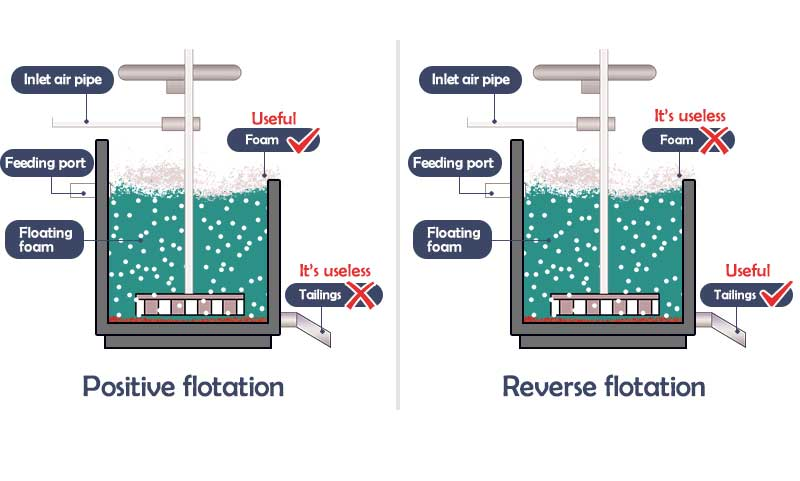

Flotation concentrate is periodically sampled to determine its purity (i.e., *%valuable*, *%gangue*). Higher *%gangue* in the concentrate is undesirable as it indicates that most valuable minerals had gone into the tailing. Purity measurement is usually done in a lab and can take some time before process engineers can make any adjustments based on the results. A timely investigation of concentrate purity is, therefore, a fundamental aspect for the control and optimization of the flotation process.

This project explores the application of machine learning to predict gangue (*%silica*) in the flotation concentrate. The prediction will help process engineers assess purity of flotation concentrate and take corrective actions in advance. More specifically, the goal is to tackle the following task:
- **To predict the last column (dependent variable), which is the % of silica in the iron ore concentrate.**

##**2. Data Understanding**

###**2.1. Data Definitions**

- **Date**: Data collection time.
- **% Iron Feed**: Feed grade of iron-containing ore.
- **% Silica Feed**: Feed grade of silica-containing ore.
- **Starch Flow**: Depressant chemical for Iron(Fe) containing ore measured in m³/h.
- **Amina Flow**: Collector chemical for Silica containing ore measured in m³/h.
- **Ore Pulp Flow**: The amount of pulp flow fed to the flotation columns as the product of the previous process step measured in t/h.
- **Ore Pulp pH**: pH is measured in pH scale.
- **Ore Pulp Density**: The solid percent of ore fed density ranges in kg/cm³
- **Flotation Column 01, 02, 03, 04, 05, 06, 07 Air Flow**: Air Flows that goes into the flotation cell measured in Nm³/h.
- **Flotation Column 01, 02, 03, 04, 05, 06, 07 Level**: Froth level in the flotation cell measured in mm.
- **% Iron Concentrate**: Concentrate grade of iron-containing ore in percentage.
- **% Silica Concentrate**: Concentrate grade of silica-containing ore in percentage

###**2.2. Inspection of the data**

- The first column shows time and date range (march 2017 -  september 2017). 
- Some columns were sampled every 20 second. Others were sampled on a hourly base.
- The second and third columns are quality measures of the iron ore pulp right before it is fed into the flotation plant. 
- From Column 4 until column 8 are the most important variables that impact in the ore quality in the end of the process. 
- From column 9 until column 22, we can see process data (froth level and air flow inside the flotation columns, which also impact in ore quality). 
- The last two columns are the final iron ore pulp quality measurement from the lab. 

##**3. Data Collection**

###**3.1. Import Libraries and Modules**

In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import joblib
import warnings
warnings.filterwarnings("ignore")

###**3.2. Import Dataset**

In [36]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive/')

%cd /content/drive/My Drive/Flotation/

flotation = pd.read_csv('Flotation_Plant.csv', decimal = ",")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/Flotation


In [37]:
# Use a function to reduce memory usage of the dataframe by modifying the datatypes
def reduce_mem_usage(flotation, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = flotation.memory_usage().sum() / 1024**2    
    for col in flotation.columns:
        col_type = flotation[col].dtypes
        if col_type in numerics:
            c_min = flotation[col].min()
            c_max = flotation[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    flotation[col] = flotation[col].astype(np.int8)
                elif c_min > flotation.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                       flotation[col] = flotation[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    flotation[col] = flotation[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    flotation[col] = flotation[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    flotation[col] = flotation[col].astype(np.float32)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    flotation[col] = flotation[col].astype(np.float32)
                else:
                    flotation[col] = flotation[col].astype(np.float64)    
    end_mem = flotation.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return flotation

In [38]:
flotation = reduce_mem_usage(flotation)

Mem. usage decreased to 70.33 Mb (47.9% reduction)


- Memory usage decrased from 135.0+ MB to 70.33 MB

##**4. Data Preprocessing**

###**4.1. Dataset information**

In [39]:
flotation.head()

,date,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,...,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
0,2017-03-10 01:00:00,55.200001,16.98,3019.530029,557.434021,395.713013,10.0664,1.74,249.214005,253.235001,...,250.884003,457.395996,432.962006,424.954010,443.558014,502.255005,446.369995,523.343994,66.910004,1.31
1,2017-03-10 01:00:00,55.200001,16.98,3024.409912,563.965027,397.382996,10.0672,1.74,249.718994,250.531998,...,248.994003,451.890991,429.559998,432.938995,448.085999,496.363007,445.921997,498.075012,66.910004,1.31
2,2017-03-10 01:00:00,55.200001,16.98,3043.459961,568.054016,399.667999,10.0680,1.74,249.740997,247.873993,...,248.070999,451.239990,468.927002,434.609985,449.687988,484.411011,447.825989,458.566986,66.910004,1.31
3,2017-03-10 01:00:00,55.200001,16.98,3047.360107,568.664978,397.938995,10.0689,1.74,249.917007,254.487000,...,251.147003,452.441010,458.165009,442.864990,446.209991,471.411011,437.690002,427.669006,66.910004,1.31
4,2017-03-10 01:00:00,55.200001,16.98,3033.689941,558.166992,400.253998,10.0697,1.74,250.203003,252.136002,...,248.927994,452.441010,452.899994,450.523010,453.670013,462.597992,443.682007,425.678986,66.910004,1.31


In [40]:
flotation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 737453 entries, 0 to 737452
Data columns (total 24 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   date                          737453 non-null  object 
 1   % Iron Feed                   737453 non-null  float32
 2   % Silica Feed                 737453 non-null  float32
 3   Starch Flow                   737453 non-null  float32
 4   Amina Flow                    737453 non-null  float32
 5   Ore Pulp Flow                 737453 non-null  float32
 6   Ore Pulp pH                   737453 non-null  float32
 7   Ore Pulp Density              737453 non-null  float32
 8   Flotation Column 01 Air Flow  737453 non-null  float32
 9   Flotation Column 02 Air Flow  737453 non-null  float32
 10  Flotation Column 03 Air Flow  737453 non-null  float32
 11  Flotation Column 04 Air Flow  737453 non-null  float32
 12  Flotation Column 05 Air Flow  737453 non-nul

In [41]:
# Rename column names
old_columns = ['date', '% Iron Feed', '% Silica Feed', 'Starch Flow',
               'Amina Flow', 'Ore Pulp Flow', 'Ore Pulp pH', 'Ore Pulp Density', 
               'Flotation Column 01 Air Flow', 'Flotation Column 02 Air Flow', 
               'Flotation Column 03 Air Flow', 'Flotation Column 04 Air Flow', 
               'Flotation Column 05 Air Flow', 'Flotation Column 06 Air Flow', 
               'Flotation Column 07 Air Flow', 
               'Flotation Column 01 Level', 'Flotation Column 02 Level', 
               'Flotation Column 03 Level', 'Flotation Column 04 Level', 
               'Flotation Column 05 Level', 'Flotation Column 06 Level', 
               'Flotation Column 07 Level',
               '% Iron Concentrate', '% Silica Concentrate']
new_columns = ["date", "iron_feed", "silica_feed", "starch_flow",
               "amina_flow", "pulp_flow", "pulp_pH", "pulp_density",
               "airflow_col1", "airflow_col2", "airflow_col3", "airflow_col4", 
               "airflow_col5", "airflow_col6", "airflow_col7", 
               "level_col1", "level_col2", "level_col3", "level_col4", "level_col5", 
               "level_col6", "level_col7", "iron_conc", "silica_conc"]

flotation = flotation.rename(columns=dict(zip(old_columns, new_columns)))

In [42]:
# Drop the unnecessary column "date"
flotation.drop('date', axis=1, inplace=True)

###**4.2. Dataset summary statistics**

In [43]:
flotation.describe().T

,count,mean,std,min,25%,50%,75%,max
iron_feed,737453.0,56.294743,5.157743,42.740002,52.669998,56.080002,59.720001,65.779999
silica_feed,737453.0,14.651719,6.807439,1.310000,8.940000,13.850000,19.600000,33.400002
starch_flow,737453.0,2869.140381,1215.203735,0.002026,2076.320068,3018.429932,3727.729980,6300.229980
amina_flow,737453.0,488.144653,91.230537,241.669006,431.795990,504.393005,553.257019,739.538025
pulp_flow,737453.0,397.578400,9.699785,376.248993,394.264008,399.248993,402.967987,418.640991
pulp_pH,737453.0,9.767639,0.387007,8.753340,9.527360,9.798100,10.038000,10.808100
pulp_density,737453.0,1.680380,0.069249,1.519820,1.647310,1.697600,1.728330,1.853250
airflow_col1,737453.0,280.151886,29.621286,175.509995,250.281006,299.343994,300.148987,373.871002
airflow_col2,737453.0,277.159973,30.149357,175.156006,250.457001,296.222992,300.690002,375.992004
airflow_col3,737453.0,281.082489,28.558270,176.468994,250.854996,298.696014,300.381989,364.346008



- **iron_feed**: Percentage of iron in the slurry being fed to the flotation cells (0-100%). (Min 42.74%, max 65.78%)
- **silica_feed**: Percentage of silica in the slurry being fed to the flotation cells. (0-100%). (Min 1.31%, max 33.4%)
- **starch_flow**: Flow rate of starch (reactive) measured in m3/h. (min 0.002026 m3/h, max 6300.23 m3/h)
- **amina_flow**: Flow rate of amine (reactive) measured in m3/h. (min 241.669 m3/h, max 739.538 m3/h)
- **pulp_flow**: Feed flow rate of pulp measured in t/h. (min 376.249 t/h, max 418.641 m3/h)
- **pulp_pH**: pH of the pulp, scale from 0 to 14. (min 8.7533 ph, max 10.808ph)
- **pulp_density**: Density of the pulp measured in kg/cm³. (min 1.519 kg/cm3, max 1.853 kg/cm3)
- **airflow_col1**: Air flow rate entering flotation cell 1, measured in Nm³/h. (min 175.510 Nm3/h, max 373.871 Nm3/h)
- **airflow_col2**: Air flow rate entering flotation cell 2, measured in Nm³/h. (min 175.156 Nm3/h, max 375.992 Nm3/h)
- **airflow_col3**: Air flow rate entering flotation cell 3, measured in Nm³/h. (min 176.469 Nm3/h, max 364.346 Nm3/h)
- **airflow_col4**: Air flow rate entering flotation cell 4, measured in Nm³/h. (min 292.195 Nm3/h, max 305.871 Nm3/h)
- **airflow_col5**: Air flow rate entering flotation cell 5, measured in Nm³/h. (min 286.295 Nm3/h, max 310.27 Nm3/h)
- **airflow_col6**: Air flow rate entering flotation cell 6, measured in Nm³/h. (min 189.928 Nm3/h, max 370.91 Nm3/h)
- **airflow_col7**: Air flow rate entering flotation cell 7, measured in Nm³/h. (min 185.962 Nm3/h, max 371.593 Nm3/h)
- **level_col1**: Height of the bubble layer at the top of flotation cell 1, measured in mm. (min 149.2 mm, max 862.2 mm)
- **level_col2**: Height of the bubble layer at the top of flotation cell 2, measured in mm. (min 210.7 mm, max 828.9 mm)
- **level_col3**: Height of the bubble layer at the top of flotation cell 3, measured in mm. (min 126.2 mm, max 886.8 mm)
- **level_col4**: Height of the bubble layer at the top of flotation cell 4, measured in mm. (min 162.2 mm, max 680.3 mm)
- **level_col5**: Height of the bubble layer at the top of flotation cell 5, measured in mm. (min 166.9 mm, max 675.6 mm)
- **level_col6**: Height of the bubble layer at the top of flotation cell 6, measured in mm. (min 155.8 mm, max 698.8 mm)
- **level_col7**: Height of the bubble layer at the top of flotation cell 7, measured in mm. (min 175.3 mm, max 659.9 mm)
- **iron_conc**: Percentage of iron in the concentrate at the end of the flotation process, (min 62.05%, max 68.01%)

**```Target Variable```**
- **silica_conc**: Percentage of silica in the concentrate at the end of the flotation process, (min 0.6%, max 5.63%) 

- Dataset variables have very wide range data point values.


###**4.3. Dataset normalisation**

- Normalizing the dataset is necessary to bring the features or variables to a similar scale or range.

In [46]:
from sklearn.preprocessing import MinMaxScaler

# Select the columns to normalize
columns_to_normalize = ["iron_feed", "silica_feed", "starch_flow", "amina_flow", "pulp_flow",
                        "pulp_pH", "pulp_density", "airflow_col1", "airflow_col2", "airflow_col3",
                        "airflow_col4", "airflow_col5", "airflow_col6", "airflow_col7", "level_col1",
                        "level_col2", "level_col3", "level_col4", "level_col5", "level_col6",
                        "level_col7", "iron_conc", "silica_conc"]

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Apply Min-Max scaling to the selected columns
flotation[columns_to_normalize] = scaler.fit_transform(flotation[columns_to_normalize])


In [47]:
flotation.head()

,iron_feed,silica_feed,starch_flow,amina_flow,pulp_flow,pulp_pH,pulp_density,airflow_col1,airflow_col2,airflow_col3,...,airflow_col7,level_col1,level_col2,level_col3,level_col4,level_col5,level_col6,level_col7,iron_conc,silica_conc
0,0.540799,0.488314,0.479273,0.634233,0.459144,0.639033,0.660348,0.371565,0.388770,0.394444,...,0.349737,0.432193,0.359466,0.392732,0.542995,0.659121,0.535025,0.718177,0.815436,0.144016
1,0.540799,0.488314,0.480047,0.647351,0.498538,0.639422,0.660348,0.374111,0.375311,0.395967,...,0.339555,0.424473,0.353963,0.403231,0.551733,0.647538,0.534199,0.666028,0.815436,0.144016
2,0.540799,0.488314,0.483071,0.655564,0.552440,0.639812,0.660348,0.374222,0.362076,0.393044,...,0.334583,0.423560,0.417646,0.405428,0.554825,0.624040,0.537706,0.584493,0.815436,0.144016
3,0.540799,0.488314,0.483690,0.656791,0.511653,0.640250,0.660348,0.375109,0.395004,0.391639,...,0.351154,0.425244,0.400237,0.416282,0.548113,0.598483,0.519040,0.520727,0.815436,0.144016
4,0.540799,0.488314,0.481520,0.635705,0.566262,0.640639,0.660348,0.376551,0.383298,0.390820,...,0.339200,0.425244,0.391719,0.426350,0.562510,0.581157,0.530074,0.516621,0.815436,0.144016


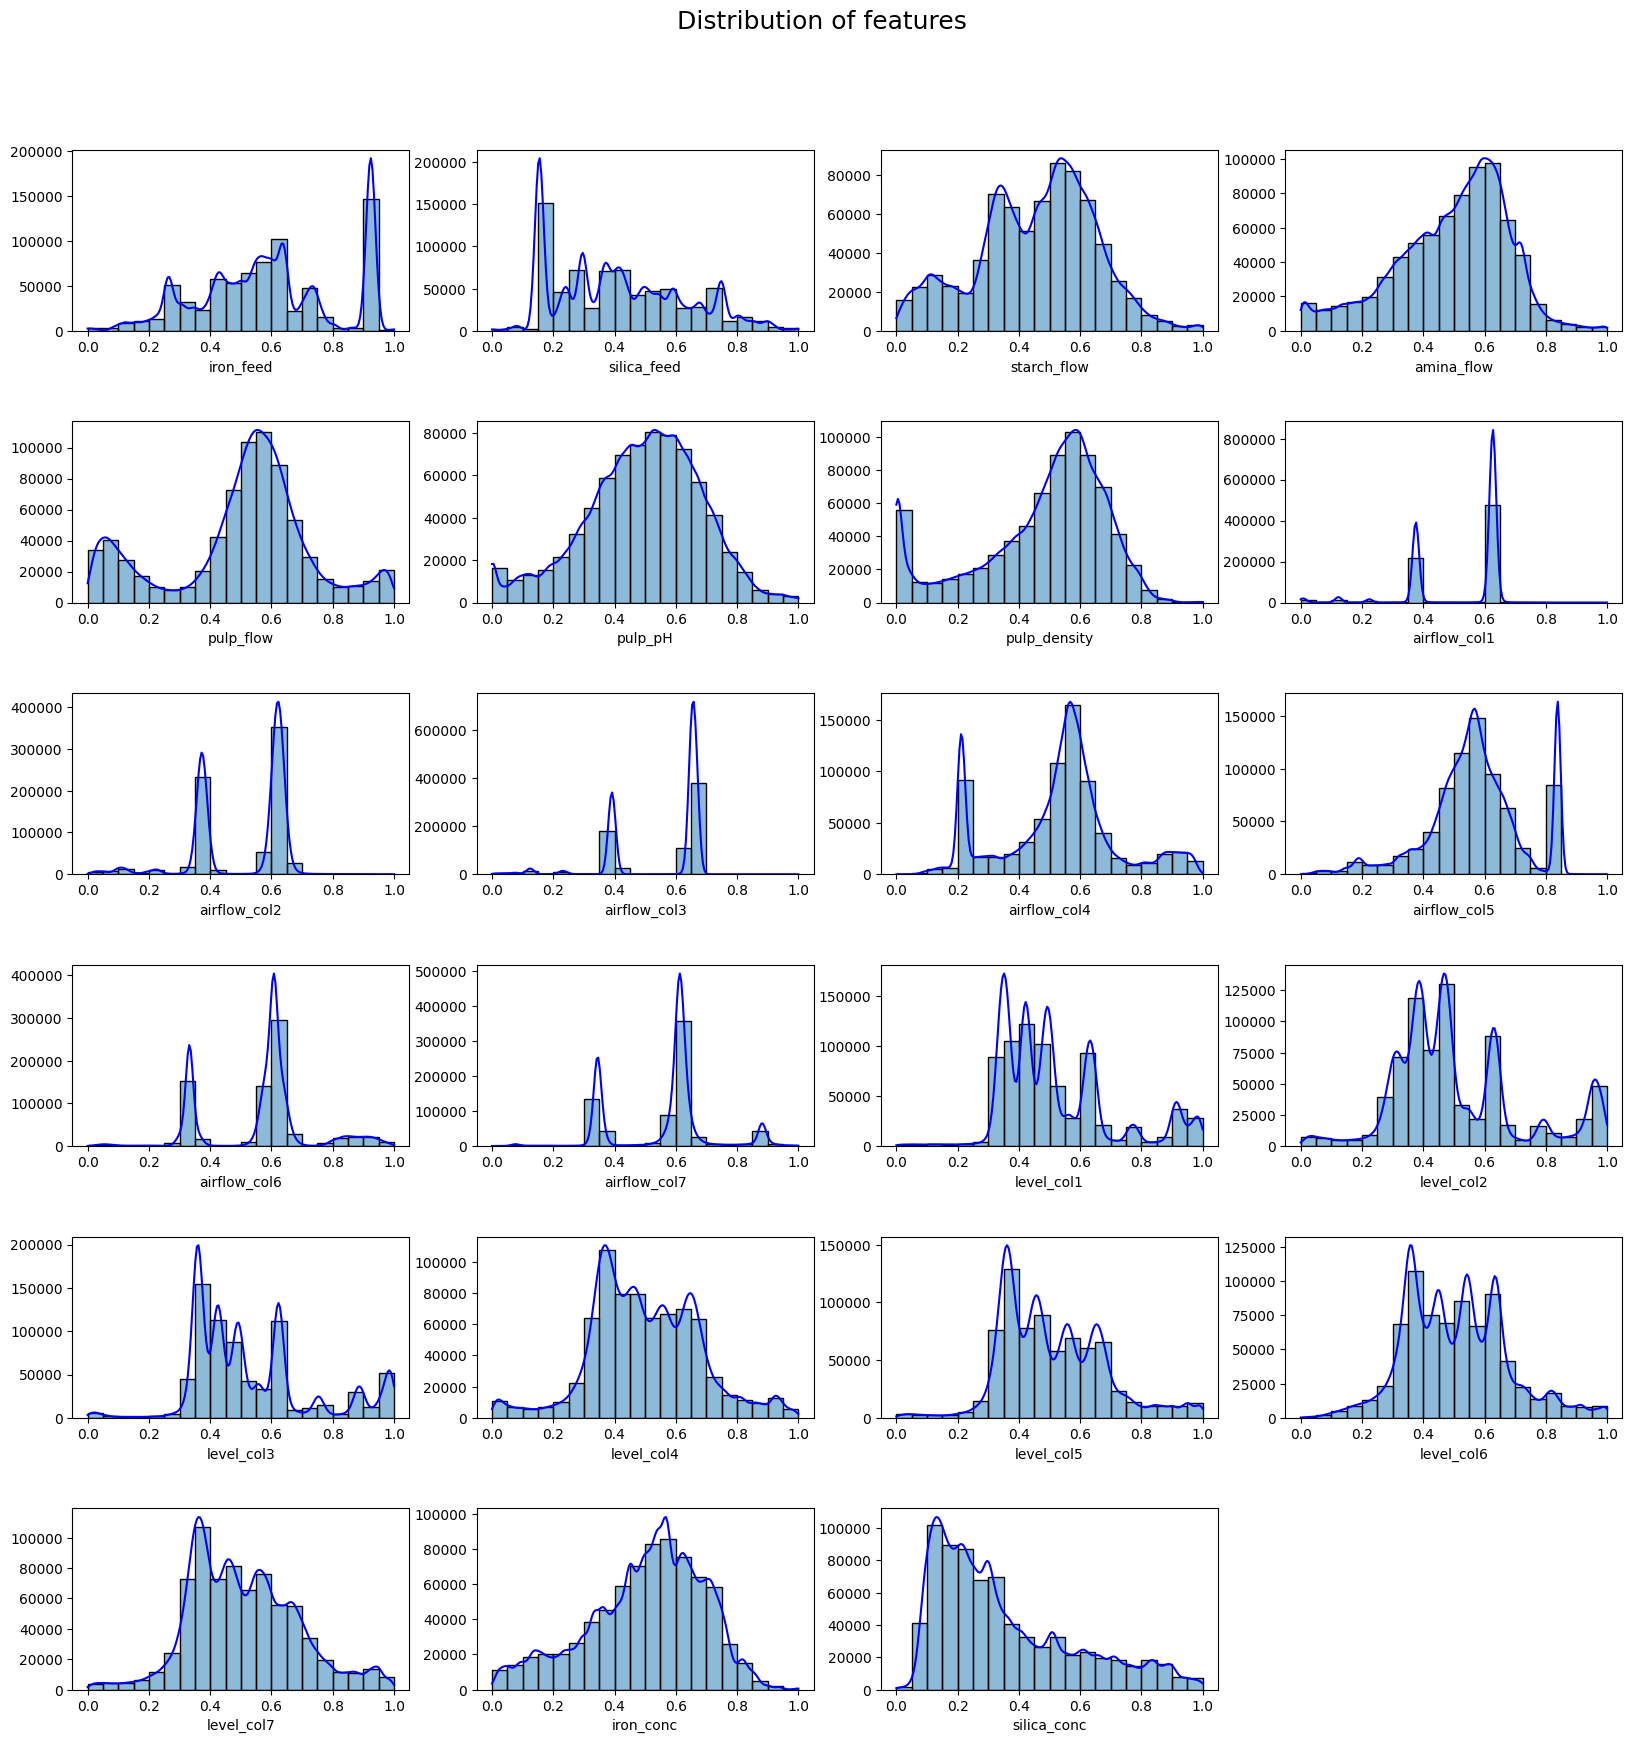

In [48]:
features = flotation.columns
plt.figure(figsize= (20,20))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Distribution of features", fontsize=18, y=0.95)
for i, feature in enumerate(features):
 k = i + 1
 plt.subplot(6,4,int(k))
 sns.histplot(data = flotation, x= feature, kde=True, bins = 20).lines[0].set_color('blue')
 plt.xlabel(feature)
 plt.ylabel("")
plt.show()

###**4.3. Corellation between the variables**

In [49]:
# Calculate the correlation matrix
correlation_matrix = flotation.corr()
correlation_matrix

,iron_feed,silica_feed,starch_flow,amina_flow,pulp_flow,pulp_pH,pulp_density,airflow_col1,airflow_col2,airflow_col3,...,airflow_col7,level_col1,level_col2,level_col3,level_col4,level_col5,level_col6,level_col7,iron_conc,silica_conc
iron_feed,1.000000,-0.971833,0.027981,-0.088148,0.160705,0.007451,-0.125518,-0.062379,-0.169430,-0.062207,...,-0.016356,0.029499,0.020839,0.015191,0.016108,0.023288,0.003694,0.025723,0.055424,-0.077052
silica_feed,-0.971833,1.000000,-0.016073,0.078735,-0.150788,0.008014,0.104497,0.091757,0.182573,0.084197,...,0.045300,-0.038291,-0.036968,-0.022675,-0.034050,-0.043753,-0.019502,-0.046413,-0.044168,0.072724
starch_flow,0.027981,-0.016073,1.000000,0.254748,0.042703,0.263020,0.226004,0.191131,0.186585,0.183288,...,0.194786,-0.294380,-0.278422,-0.301757,-0.012612,-0.055528,-0.071722,-0.038193,0.069657,-0.066394
amina_flow,-0.088148,0.078735,0.254748,1.000000,0.212252,0.123690,0.655788,0.111321,0.122911,0.101957,...,0.079558,-0.268536,-0.234454,-0.286968,-0.180301,-0.211712,-0.197758,-0.168050,-0.110148,0.156701
pulp_flow,0.160705,-0.150788,0.042703,0.212252,1.000000,0.118376,0.012279,-0.137866,-0.118549,-0.140761,...,-0.140914,-0.008579,-0.008049,-0.054351,-0.009784,0.002260,-0.016661,0.016585,0.083120,0.008222
pulp_pH,0.007451,0.008014,0.263020,0.123690,0.118376,1.000000,0.115189,0.163073,0.144935,0.193372,...,0.174684,-0.165739,-0.153557,-0.140070,0.046371,0.013041,-0.075034,0.019021,0.192992,-0.147739
pulp_density,-0.125518,0.104497,0.226004,0.655788,0.012279,0.115189,1.000000,-0.005142,0.025794,-0.031673,...,-0.052294,-0.111608,-0.093024,-0.149584,-0.087761,-0.140881,-0.099817,-0.086067,0.015580,0.046984
airflow_col1,-0.062379,0.091757,0.191131,0.111321,-0.137866,0.163073,-0.005142,1.000000,0.848277,0.954528,...,0.646768,-0.441573,-0.425758,-0.371791,-0.061940,-0.091386,-0.118992,-0.110726,0.098599,-0.219158
airflow_col2,-0.169430,0.182573,0.186585,0.122911,-0.118549,0.144935,0.025794,0.848277,1.000000,0.860438,...,0.578578,-0.432033,-0.422855,-0.365535,-0.074312,-0.110512,-0.117619,-0.112403,0.058744,-0.167398
airflow_col3,-0.062207,0.084197,0.183288,0.101957,-0.140761,0.193372,-0.031673,0.954528,0.860438,1.000000,...,0.649435,-0.440823,-0.420932,-0.364773,-0.046685,-0.063693,-0.100419,-0.085294,0.100137,-0.218891


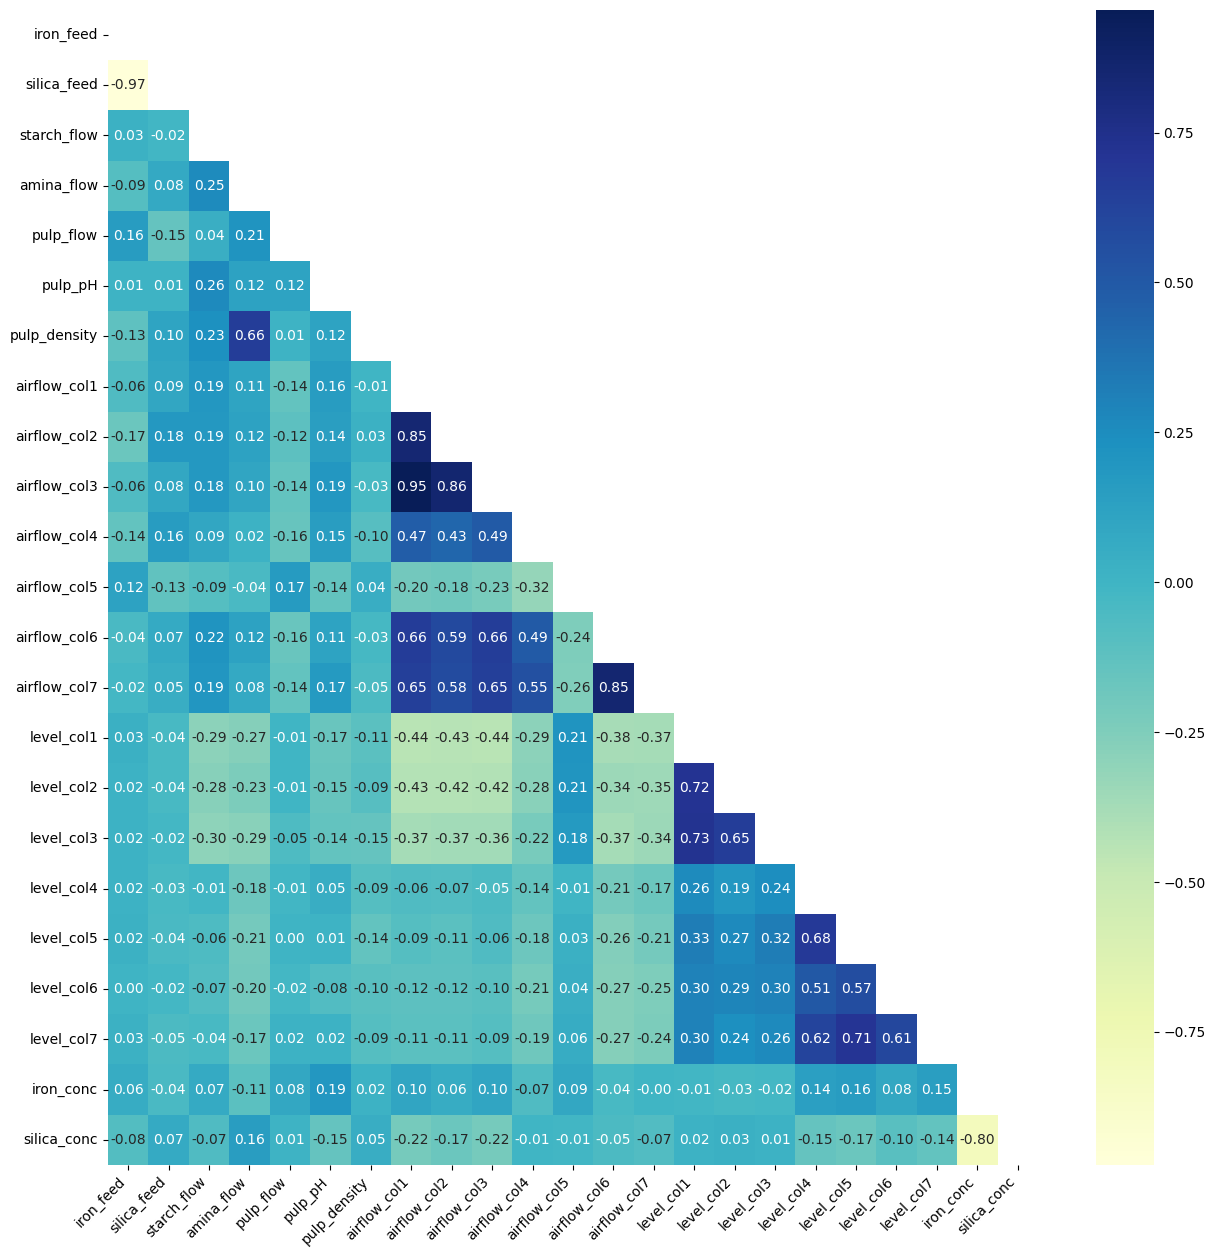

In [50]:
# Plot corellation martix heatmap of variables
fig, ax = plt.subplots(figsize=(15, 15))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

sns.heatmap(correlation_matrix, mask=mask, 
            annot=True, fmt=".2f", cmap="YlGnBu")

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

plt.show()

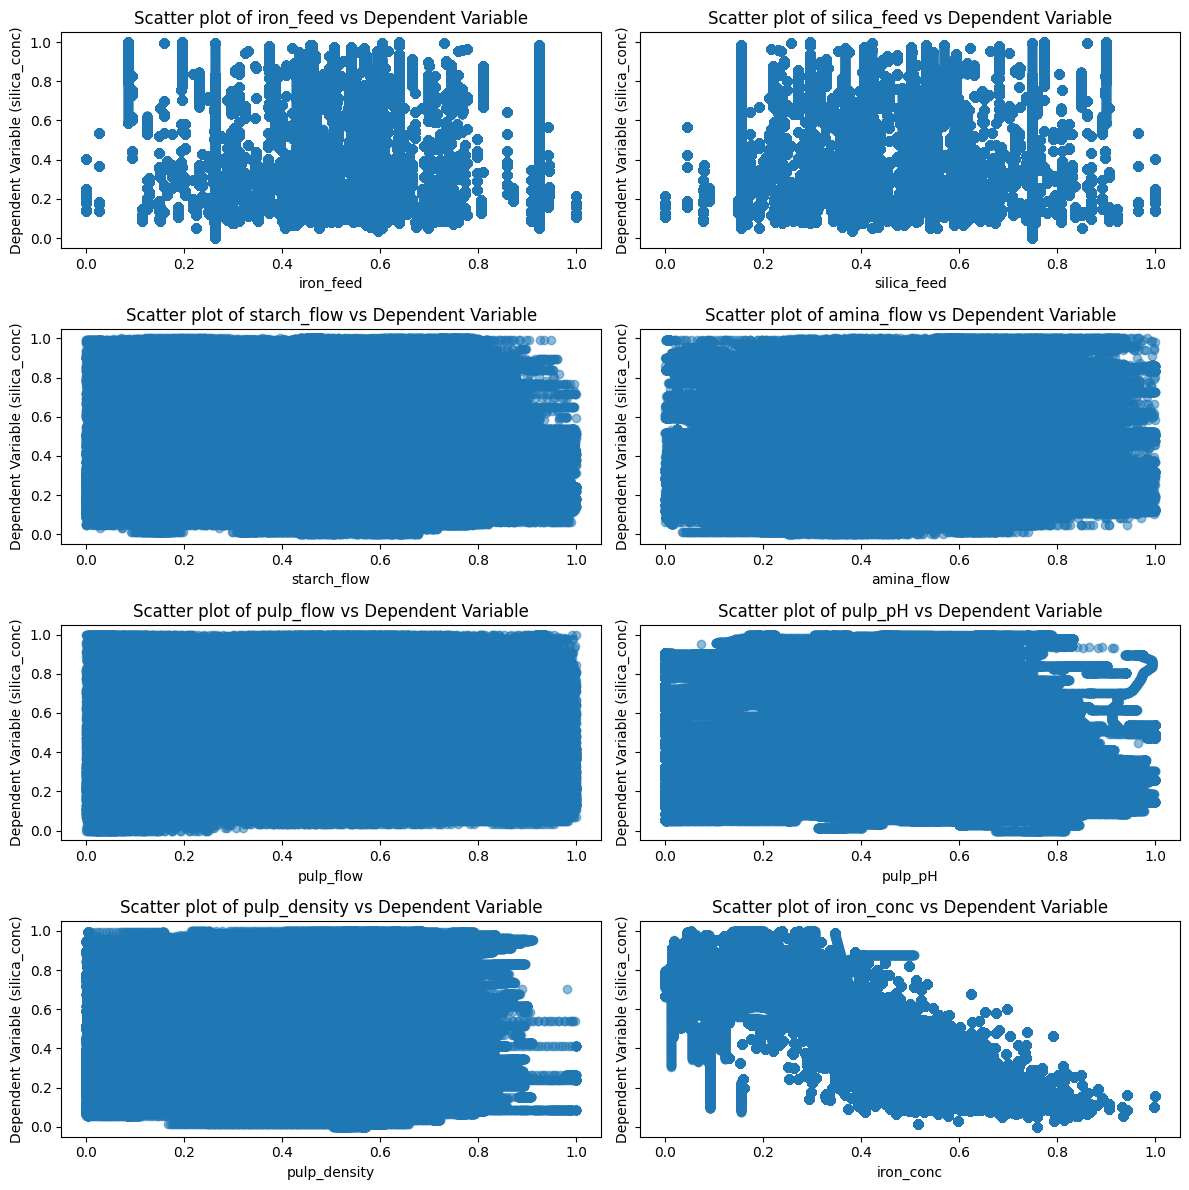

In [51]:
colnames = ["iron_feed", "silica_feed", "starch_flow", "amina_flow", "pulp_flow",
            "pulp_pH", "pulp_density", "iron_conc"]

target = "silica_conc"

# Create subplots for each independent variable
fig, axes = plt.subplots(4, 2, figsize=(12, 12), sharey=True)
axes = axes.flatten()


for i, colname in enumerate(colnames):
    ax = axes[i]
    ax.scatter(flotation[colname], flotation[target], alpha=0.5)
    ax.set_xlabel(colname)
    ax.set_ylabel("Dependent Variable (silica_conc)")
    ax.set_title(f"Scatter plot of {colname} vs Dependent Variable")

# Remove empty subplots if there are any
if len(colnames) < len(axes):
    for j in range(len(colnames), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


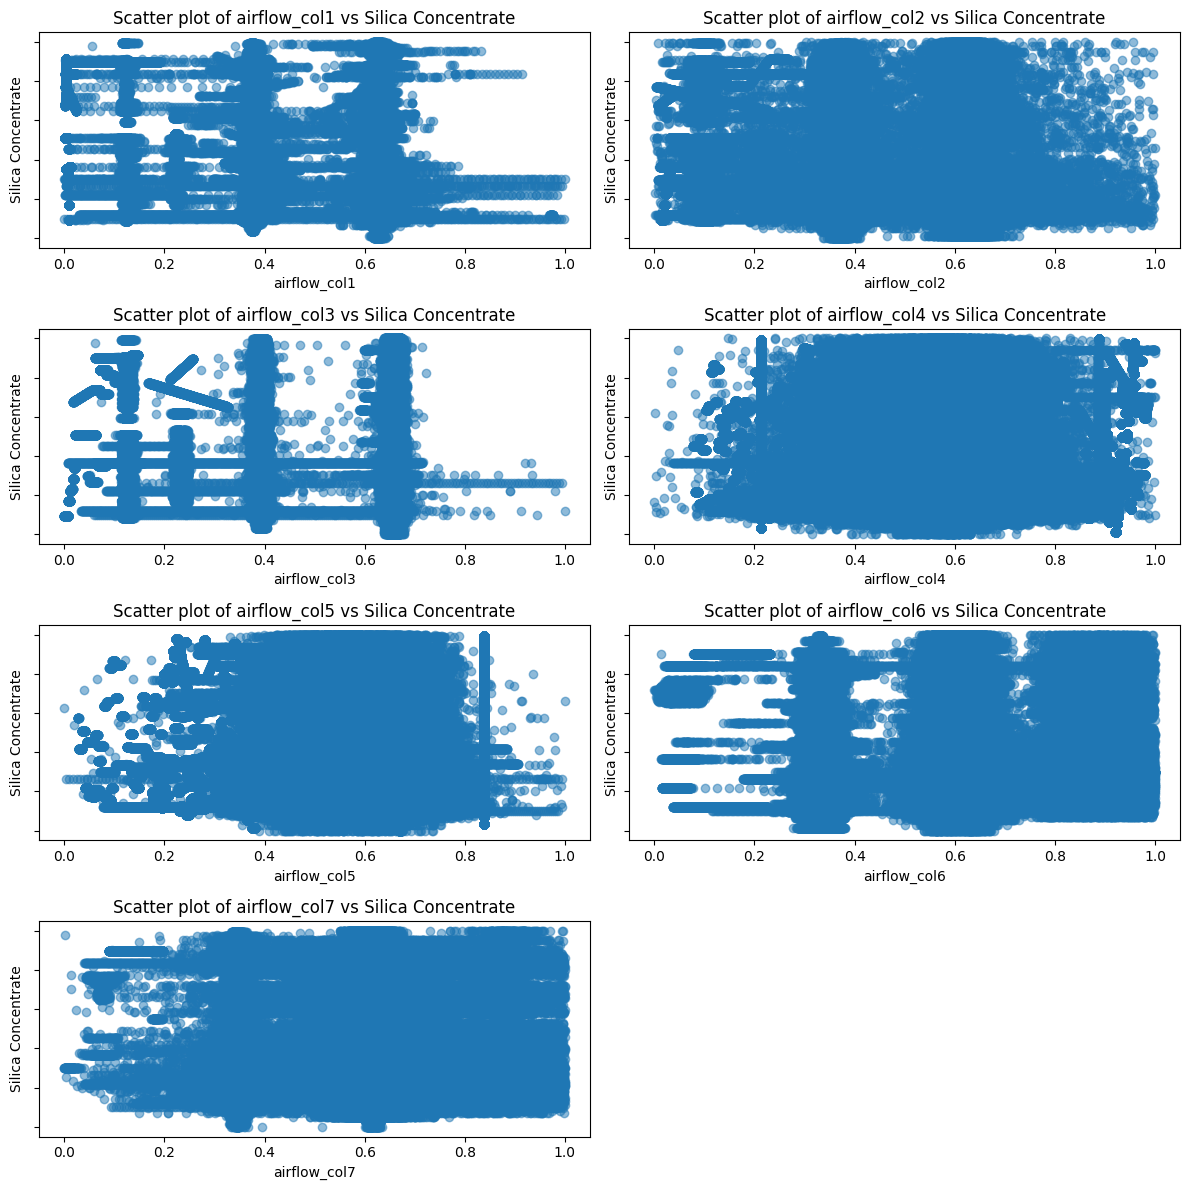

In [52]:
colnames = ["airflow_col1", "airflow_col2", "airflow_col3", 
            "airflow_col4", "airflow_col5", "airflow_col6", "airflow_col7"]

target = "silica_conc"

fig, axes = plt.subplots(4, 2, figsize=(12, 12), sharey=True)
axes = axes.flatten()

# Plot each independent variable separately
for i, colname in enumerate(colnames):
    ax = axes[i]
    ax.scatter(flotation[colname], flotation[target], alpha=0.5)
    ax.set_xlabel(colname)
    ax.set_ylabel("Silica Concentrate")
    ax.set_title(f"Scatter plot of {colname} vs Silica Concentrate")
    ax.set_yticklabels([colname], rotation=45)

if len(colnames) < len(axes):
    for j in range(len(colnames), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

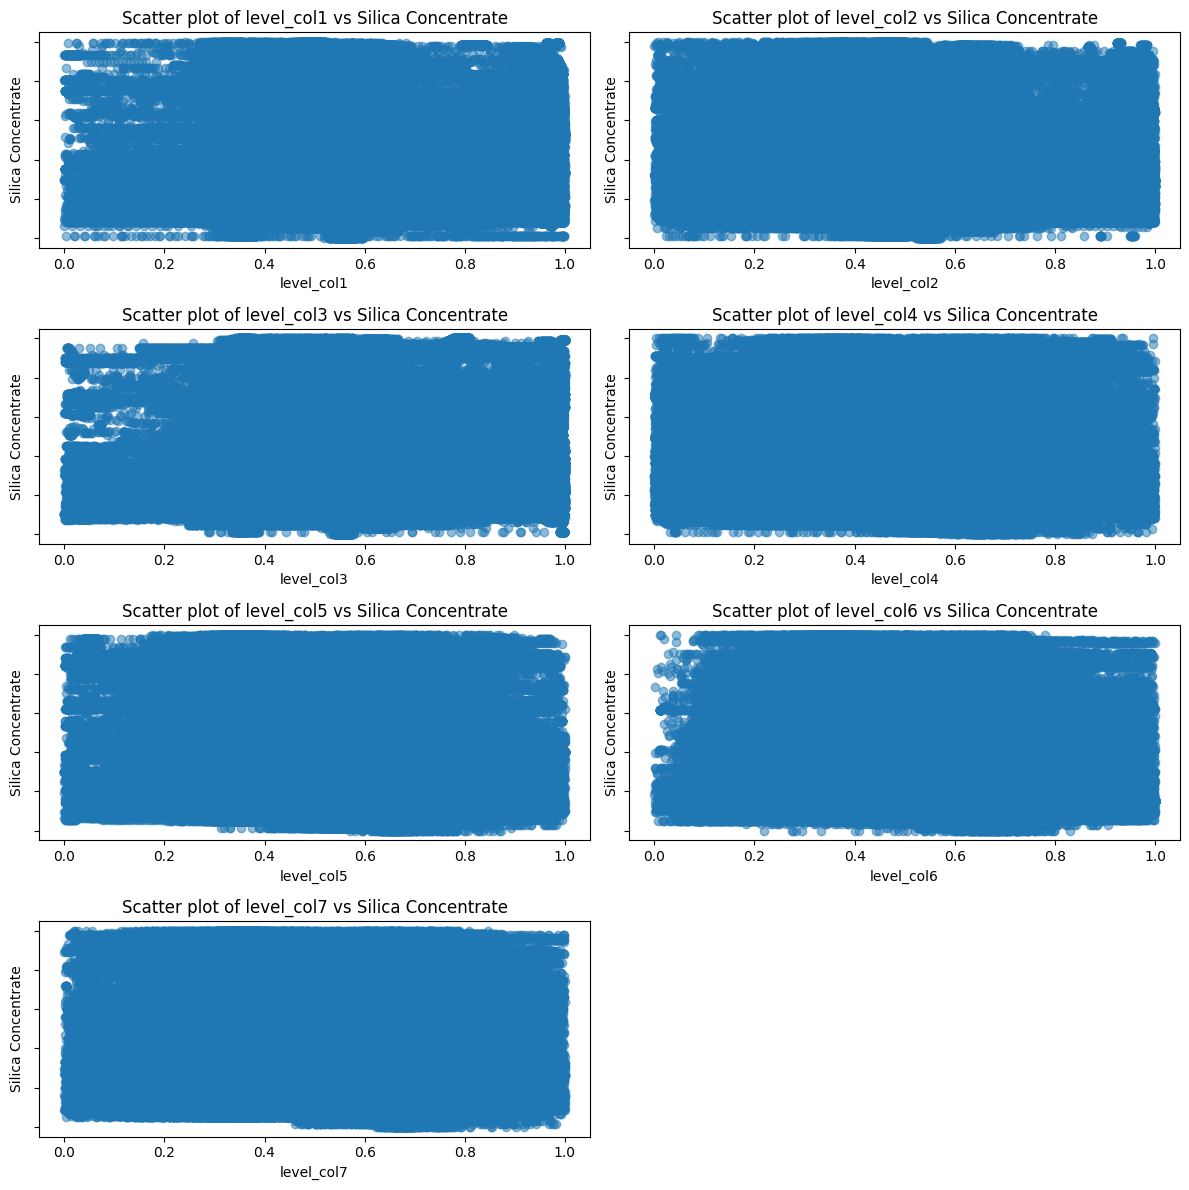

In [53]:
colnames = ["level_col1", "level_col2", "level_col3",
            "level_col4", "level_col5", "level_col6", "level_col7"]

target = "silica_conc"

fig, axes = plt.subplots(4, 2, figsize=(12, 12), sharey=True)
axes = axes.flatten()

# Plot each independent variable separately
for i, colname in enumerate(colnames):
    ax = axes[i]
    ax.scatter(flotation[colname], flotation[target], alpha=0.5)
    ax.set_xlabel(colname)
    ax.set_ylabel("Silica Concentrate")
    ax.set_title(f"Scatter plot of {colname} vs Silica Concentrate")
    ax.set_yticklabels([colname], rotation=45)

if len(colnames) < len(axes):
    for j in range(len(colnames), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


###**4.4. Check Missing Values**

In [54]:
total = flotation.isnull().sum()
percent = (flotation.isnull().sum()/flotation.isnull().count())
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
iron_feed,0,0.0
silica_feed,0,0.0
starch_flow,0,0.0
amina_flow,0,0.0
pulp_flow,0,0.0
pulp_pH,0,0.0
pulp_density,0,0.0
airflow_col1,0,0.0
airflow_col2,0,0.0
airflow_col3,0,0.0


- No missing values across the dataframe

###**4.5. Check Duplicated Values**

In [55]:
#check duplicated rows
duplicate_rows = flotation[flotation.duplicated()]
duplicate_rows.shape

(1171, 23)

- There are 1171 duplicated values

In [56]:
#drop duplicated rows
flotation = flotation.drop_duplicates()
flotation.shape

(736282, 23)

In [57]:
flotation.shape

(736282, 23)

- Now dataset has 736282 data points.

###**4.6. Check Outliers**

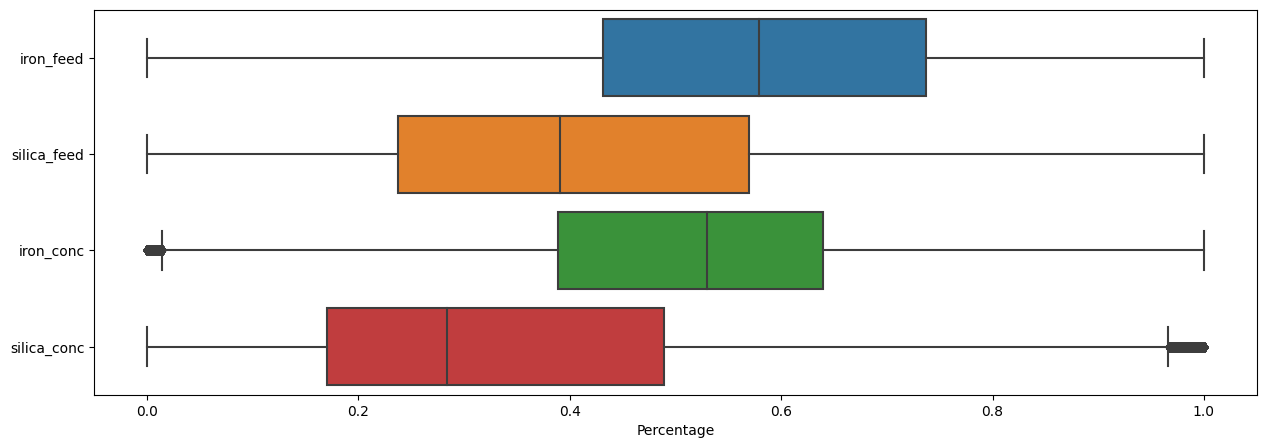

In [64]:
#box plots of input and output values 
plt.figure(figsize = (15, 5))
sns.boxplot(data = flotation[["iron_feed", "silica_feed", "iron_conc", "silica_conc"]], orient = 'h')
plt.xlabel('Percentage');

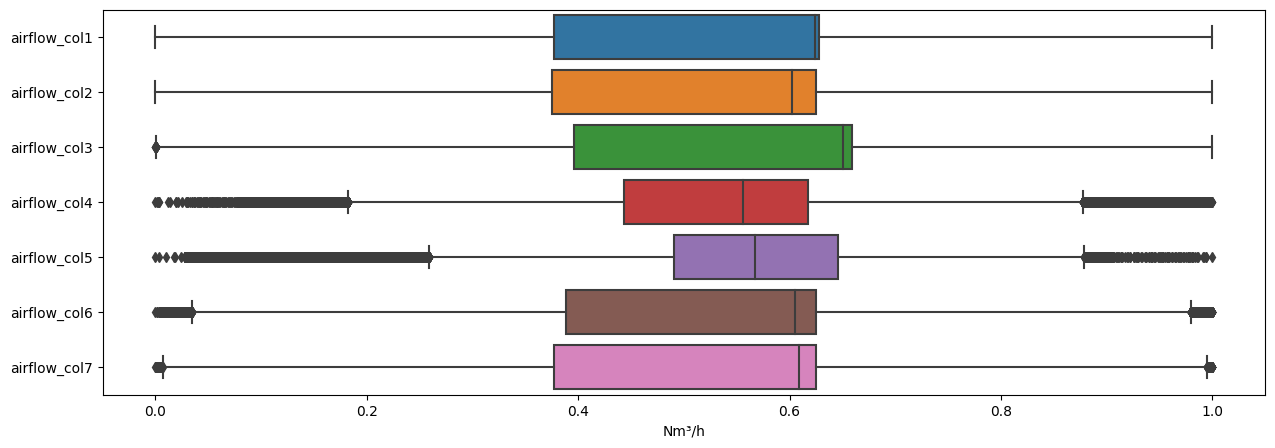

In [59]:
#box plots of airflow values 
plt.figure(figsize = (15, 5))
sns.boxplot(data = flotation[["airflow_col1", "airflow_col2", "airflow_col3", 
                              "airflow_col4", "airflow_col5", "airflow_col6", 
                              "airflow_col7"]], orient = 'h')
plt.xlabel('Nm³/h');

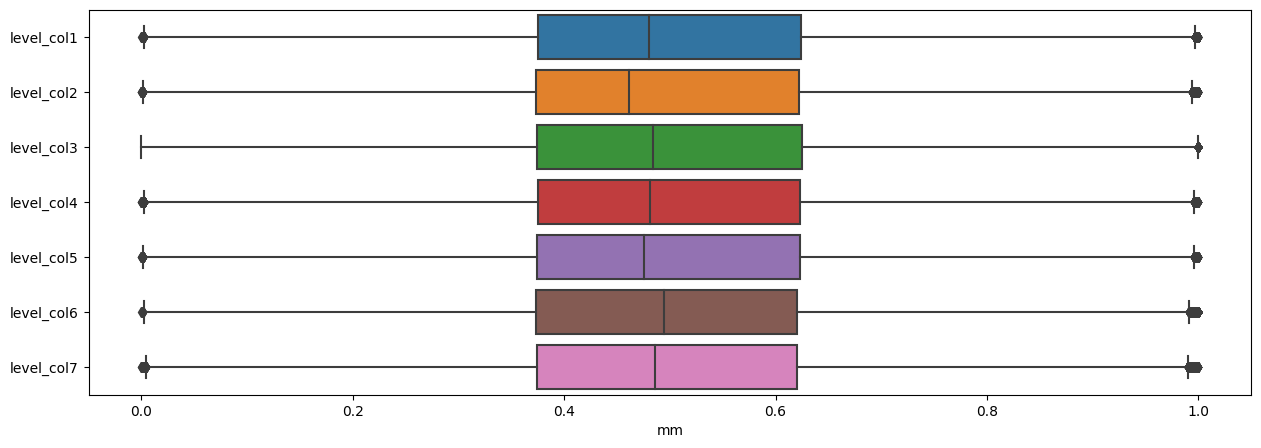

In [65]:
#box plots of froth level values 
plt.figure(figsize = (15, 5))
sns.boxplot(data = flotation[["level_col1", "level_col2", "level_col3", 
                              "level_col4", "level_col5","level_col6", 
                              "level_col7"]], orient = 'h')
plt.xlabel('mm');

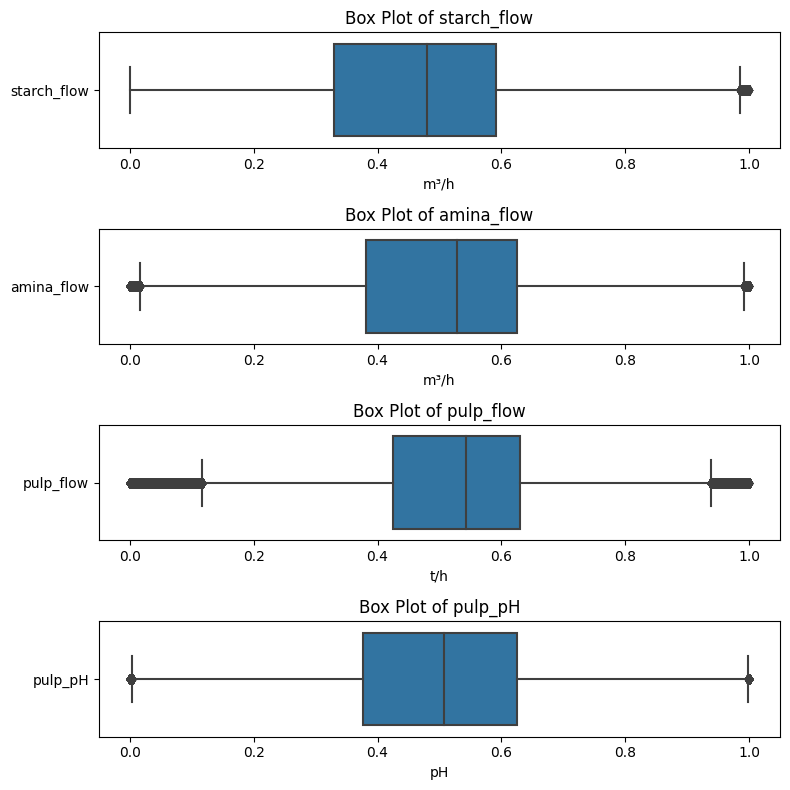

In [67]:
fig, axes = plt.subplots(4, 1, figsize=(8, 8))

# Box plots for starch_flow
sns.boxplot(data=flotation[["starch_flow"]], orient='h', ax=axes[0])
axes[0].set_xlabel('m³/h')
axes[0].set_title('Box Plot of starch_flow')

# Box plots for amina_flow
sns.boxplot(data=flotation[["amina_flow"]], orient='h', ax=axes[1])
axes[1].set_xlabel('m³/h')
axes[1].set_title('Box Plot of amina_flow')

# Box plots for pulp_flow
sns.boxplot(data=flotation[["pulp_flow"]], orient='h', ax=axes[2])
axes[2].set_xlabel('t/h')
axes[2].set_title('Box Plot of pulp_flow')

# Box plots for pulp_pH
sns.boxplot(data=flotation[["pulp_pH"]], orient='h', ax=axes[3])
axes[3].set_xlabel('pH')
axes[3].set_title('Box Plot of pulp_pH')

plt.tight_layout()
plt.show()


In [68]:
import pandas as pd
import numpy as np

# Specify the columns to consider for outlier removal
columns_to_check = ["iron_feed", "silica_feed", "starch_flow",
               "amina_flow", "pulp_flow", "pulp_pH", "pulp_density",
               "airflow_col1", "airflow_col2", "airflow_col3",
               "airflow_col4", "airflow_col5", "airflow_col6", "airflow_col7", 
               "level_col1", "level_col2", "level_col3", "level_col4", "level_col5", 
               "level_col6", "level_col7",
               "iron_conc", "silica_conc"]

# Loop over each column to identify and eliminate outliers
for column in columns_to_check:
    # Calculate the lower and upper thresholds
    lower_threshold = np.percentile(flotation[column], 25) - 1.5 * (np.percentile(flotation[column], 75) - np.percentile(flotation[column], 25))
    upper_threshold = np.percentile(flotation[column], 75) + 1.5 * (np.percentile(flotation[column], 75) - np.percentile(flotation[column], 25))
    
    # Identify outliers
    outliers = flotation[(flotation[column] < lower_threshold) | (flotation[column] > upper_threshold)]
    
    # Remove outliers
    modified_flotation = flotation[(flotation[column] >= lower_threshold) & (flotation[column] <= upper_threshold)]

In [69]:
modified_flotation.shape

(731525, 23)

Now data points of dataset has decreased from 736282 to 731525

###**4.7. Check Skewness**

In [ ]:
"iron_feed", "silica_feed", "starch_flow",
               "amina_flow", "pulp_flow", "pulp_pH", "pulp_density",
               "airflow_col1", "airflow_col2", "airflow_col3",
               "airflow_col4", "airflow_col5", "airflow_col6", "airflow_col7", 
               "level_col1", "level_col2", "level_col3", "level_col4", "level_col5", 
               "level_col6", "level_col7",
               "iron_conc", "silica_conc"

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm, probplot

def check_skewness(col):
    sns.distplot(flotation[col], fit=norm)
    fig = plt.figure()
    res = probplot(flotation[col], plot=plt)
    # Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(flotation[col])
    print('\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))


 mu = 0.29 and sigma = 0.16



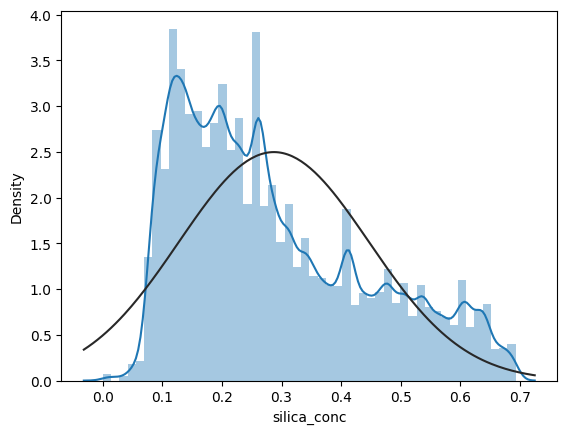

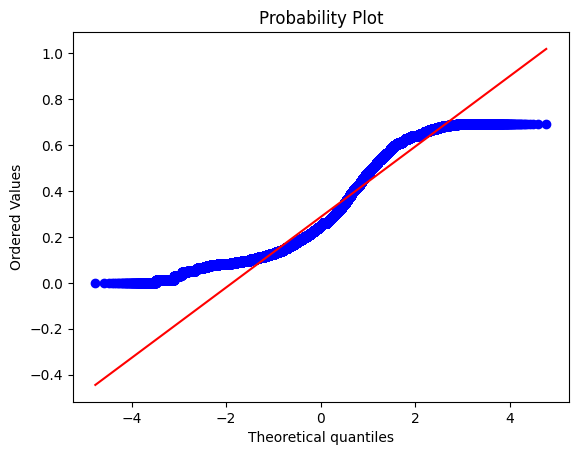

In [79]:
check_skewness("silica_conc")


 mu = 0.42 and sigma = 0.21



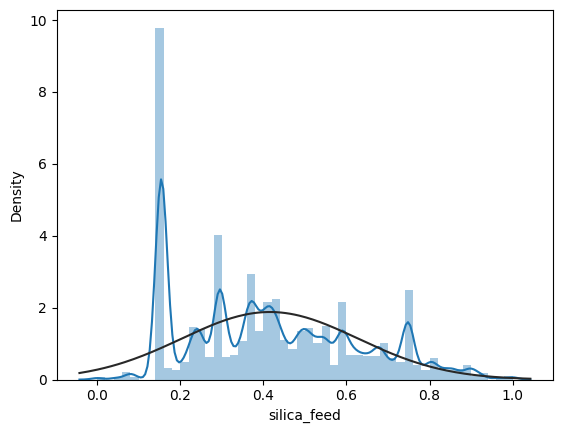

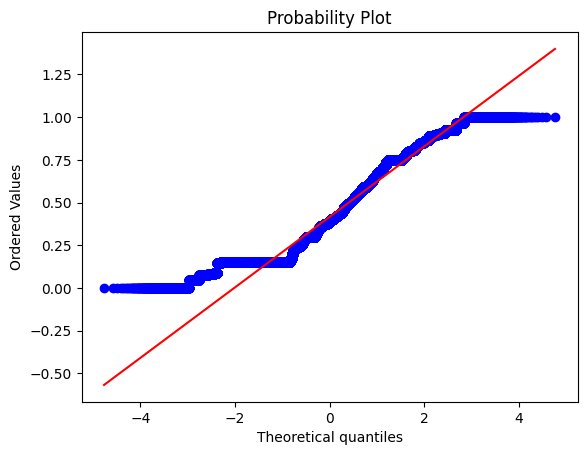

In [80]:
check_skewness("silica_feed")


 mu = 0.46 and sigma = 0.19



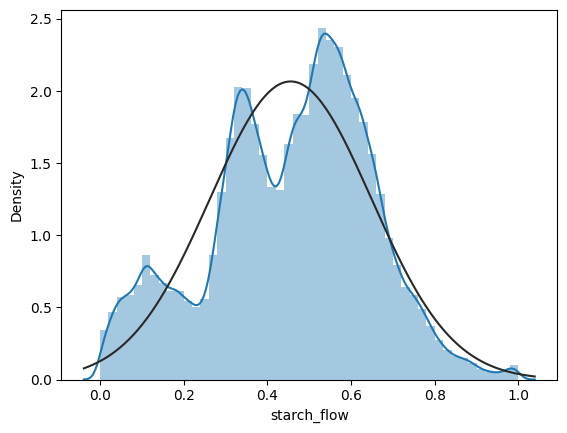

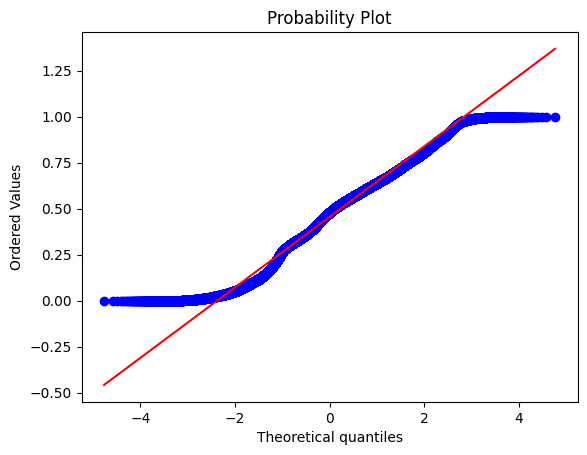

In [81]:
check_skewness("starch_flow")

This distribution is positively skewed. Notice that the black curve is more deviated towards the right. If you encounter that your predictive (response) variable is skewed, it is recommended to fix the skewness to make good decisions by the model.

Okay, So how do I fix the skewness?
The best way to fix it is to perform a log transform of the same data, with the intent to reduce the skewness.

In [76]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
flotation["silica_conc"] = np.log1p(flotation["silica_conc"])


 mu = 0.29 and sigma = 0.16



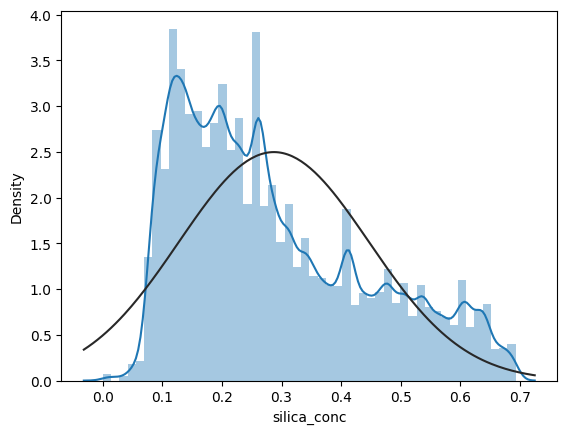

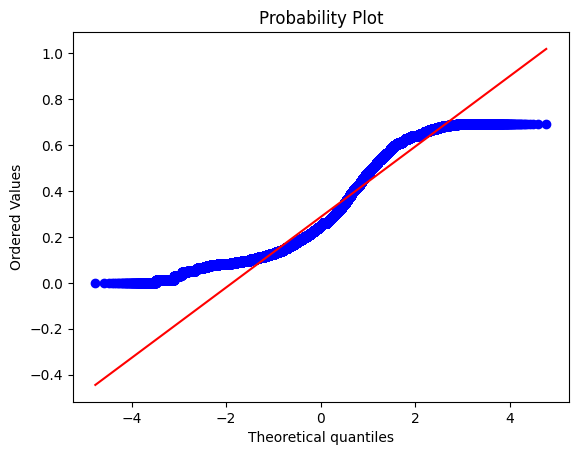

In [77]:
check_skewness("silica_conc")

##**5. Modelling**

##**6. Evaluating**

##**7. Tunning Model**